# Week 4 Programming Assignment
## Imports

In [1]:
from random import randint, uniform

import matplotlib.pyplot as plt
import networkx as nx
from pulp import *  # pyright: ignore [reportWildcardImportFromLibrary]

## Problem 1

In [2]:
def k_tsp_mtz_encoding(n, k, cost_matrix):
    # Check inputs are OK
    assert 1 <= k < n
    assert len(cost_matrix) == n, f"Cost matrix is not {n}x{n}"
    assert all(len(row) == n for row in cost_matrix), f"Cost matrix is not {n}x{n}"

    # Create decision variables
    # Binary variables
    binary_vars = [
        [LpVariable(f"x_{{{i},{j}}}", cat=LpBinary) if i != j else None for j in range(n)] for i in range(n)
    ]
    # Time stamp variables
    time_stamps = [LpVariable(f"t_{i}", lowBound=0, upBound=n) for i in range(1, n)]

    # Create the problem
    prob = LpProblem("kTSP", LpMinimize)

    # Add the objective function
    prob += lpSum(
        lpSum(cost_matrix[i][j] * binary_vars[i][j] for j in filter(lambda x: x != i, range(n)))
        for i in range(n)
    )

    # Add the degree constraints
    # Vertex 0
    num_enter = lpSum(binary_vars[j][0] for j in range(1, n))
    num_leave = lpSum(binary_vars[0][j] for j in range(1, n))
    prob += num_enter == k
    prob += num_leave == k

    # All the other vertices
    for i in range(1, n):
        num_enter = lpSum(binary_vars[j][i] for j in filter(lambda x: x != i, range(n)))
        num_leave = lpSum(binary_vars[i][j] for j in filter(lambda x: x != i, range(n)))
        prob += num_enter == 1
        prob += num_leave == 1

    # Add time stamp constraints
    for i in range(1, n):
        for j in filter(lambda x: x != i, range(1, n)):
            x = binary_vars[i][j]
            assert x is not None
            prob += time_stamps[j - 1] >= time_stamps[i - 1] + x - (1 - x) * (n + 1)

    # Solve the problem
    prob.solve(PULP_CBC_CMD(msg=False))
    status = LpStatus[prob.status]
    assert status == "Optimal", f"Unexpected non-optimal status: {status}"

    # Extract tours
    tours = []

    # Get all second vertices
    second = [j for j, x in enumerate(binary_vars[0]) if x is not None and x.varValue > 0]  # pyright: ignore [reportOptionalOperand]
    assert len(second) == k, "Could not find second vertex for each salesman"

    for v in second:
        tour = [0, v]

        while True:
            nxt = [j for j, x in enumerate(binary_vars[tour[-1]]) if x is not None and x.varValue > 0]  # pyright: ignore [reportOptionalOperand]
            assert len(nxt) == 1
            if nxt[0] == 0:
                break
            tour.append(nxt[0])

        tours.append(tour)

    return tours

In [3]:
n = 5
k = 2
cost_matrix = [
    [None, 3, 4, 3, 5],
    [1, None, 2, 4, 1],
    [2, 1, None, 5, 4],
    [1, 1, 5, None, 4],
    [2, 1, 3, 5, None],
]
all_tours = k_tsp_mtz_encoding(n, k, cost_matrix)
print(f"Your code returned tours: {all_tours}")
assert len(all_tours) == k, f"k={k} must yield {k} tours -- your code returns {len(all_tours)} tours instead"

tour_cost = 0
for tour in all_tours:
    assert tour[0] == 0, "Each salesperson tour must start from vertex 0"
    i = 0
    for j in tour[1:]:
        tour_cost += cost_matrix[i][j]
        i = j
    tour_cost += cost_matrix[i][0]
print(f"Tour cost obtained by your code: {tour_cost}")
assert abs(tour_cost - 12) <= 0.001, f"Expected tour cost is 12, your code returned {tour_cost}"

for i in range(1, n):
    is_in_tour = [i in tour for tour in all_tours]
    assert sum(is_in_tour) == 1, f"Vertex {i} is in {sum(is_in_tour)} tours -- this is incorrect"

print("Test passed: 3 points")

Your code returned tours: [[0, 2, 1, 4], [0, 3]]
Tour cost obtained by your code: 12
Test passed: 3 points


In [4]:
n = 5
k = 3
cost_matrix = [
    [None, 3, 4, 3, 5],
    [1, None, 2, 4, 1],
    [2, 1, None, 5, 4],
    [1, 1, 5, None, 4],
    [2, 1, 3, 5, None],
]
all_tours = k_tsp_mtz_encoding(n, k, cost_matrix)
print(f"Your code returned tours: {all_tours}")
assert len(all_tours) == k, f"k={k} must yield {k} tours -- your code returns {len(all_tours)} tours instead"

tour_cost = 0
for tour in all_tours:
    assert tour[0] == 0, "Each salesperson tour must start from vertex 0"
    i = 0
    for j in tour[1:]:
        tour_cost += cost_matrix[i][j]
        i = j
    tour_cost += cost_matrix[i][0]
print(f"Tour cost obtained by your code: {tour_cost}")
assert abs(tour_cost - 16) <= 0.001, f"Expected tour cost is 16, your code returned {tour_cost}"

for i in range(1, n):
    is_in_tour = [i in tour for tour in all_tours]
    assert sum(is_in_tour) == 1, f"Vertex {i} is in {sum(is_in_tour)} tours -- this is incorrect"

print("Test passed: 2 points")

Your code returned tours: [[0, 1, 4], [0, 2], [0, 3]]
Tour cost obtained by your code: 16
Test passed: 2 points


In [5]:
n = 8
k = 2
cost_matrix = [
    [None, 1, 1, 1, 1, 1, 1, 1],
    [0, None, 1, 2, 1, 1, 1, 1],
    [1, 0, None, 1, 2, 2, 2, 1],
    [1, 2, 2, None, 0, 1, 2, 1],
    [1, 1, 1, 1, None, 1, 1, 1],
    [0, 1, 2, 1, 1, None, 1, 1],
    [1, 0, 1, 2, 2, 2, None, 1],
    [1, 2, 2, 0, 1, 2, 1, None],
]
all_tours = k_tsp_mtz_encoding(n, k, cost_matrix)
print(f"Your code returned tours: {all_tours}")
assert len(all_tours) == k, f"k={k} must yield {k} tours -- your code returns {len(all_tours)} tours instead"

tour_cost = 0
for tour in all_tours:
    assert tour[0] == 0, "Each salesperson tour must start from vertex 0"
    i = 0
    for j in tour[1:]:
        tour_cost += cost_matrix[i][j]
        i = j
    tour_cost += cost_matrix[i][0]
print(f"Tour cost obtained by your code: {tour_cost}")
assert abs(tour_cost - 4) <= 0.001, f"Expected tour cost is 4, your code returned {tour_cost}"

for i in range(1, n):
    is_in_tour = [i in tour for tour in all_tours]
    assert sum(is_in_tour) == 1, f"Vertex {i} is in {sum(is_in_tour)} tours -- this is incorrect"

print("Test passed: 3 points")

Your code returned tours: [[0, 6, 2, 1], [0, 7, 3, 4, 5]]
Tour cost obtained by your code: 4
Test passed: 3 points


In [6]:
n = 8
k = 4
cost_matrix = [
    [None, 1, 1, 1, 1, 1, 1, 1],
    [0, None, 1, 2, 1, 1, 1, 1],
    [1, 0, None, 1, 2, 2, 2, 1],
    [1, 2, 2, None, 0, 1, 2, 1],
    [1, 1, 1, 1, None, 1, 1, 1],
    [0, 1, 2, 1, 1, None, 1, 1],
    [1, 0, 1, 2, 2, 2, None, 1],
    [1, 2, 2, 0, 1, 2, 1, None],
]
all_tours = k_tsp_mtz_encoding(n, k, cost_matrix)
print(f"Your code returned tours: {all_tours}")
assert len(all_tours) == k, f"k={k} must yield {k} tours -- your code returns {len(all_tours)} tours instead"

tour_cost = 0
for tour in all_tours:
    assert tour[0] == 0, "Each salesperson tour must start from vertex 0"
    i = 0
    for j in tour[1:]:
        tour_cost += cost_matrix[i][j]
        i = j
    tour_cost += cost_matrix[i][0]
print(f"Tour cost obtained by your code: {tour_cost}")
assert abs(tour_cost - 6) <= 0.001, f"Expected tour cost is 6, your code returned {tour_cost}"

for i in range(1, n):
    is_in_tour = [i in tour for tour in all_tours]
    assert sum(is_in_tour) == 1, f"Vertex {i} is in {sum(is_in_tour)} tours -- this is incorrect"

print("Test passed: 2 points")

Your code returned tours: [[0, 2], [0, 5], [0, 6, 1], [0, 7, 3, 4]]
Tour cost obtained by your code: 6
Test passed: 2 points


In [7]:
def create_cost(n):
    return [[uniform(0, 5) if i != j else None for j in range(n)] for i in range(n)]


for trial in range(5):
    print(f"Trial #{trial}")

    n = randint(5, 11)
    k = randint(2, n // 2)
    print(f"n={n}, k={k}")

    cost_matrix = create_cost(n)
    print("cost_matrix =")
    print(cost_matrix)

    all_tours = k_tsp_mtz_encoding(n, k, cost_matrix)
    print(f"Your code returned tours: {all_tours}")
    assert (
        len(all_tours) == k
    ), f"k={k} must yield {k} tours -- your code returns {len(all_tours)} tours instead"

    tour_cost = 0
    for tour in all_tours:
        assert tour[0] == 0, "Each salesperson tour must start from vertex 0"
        i = 0
        for j in tour[1:]:
            tour_cost += cost_matrix[i][j]
            i = j
        tour_cost += cost_matrix[i][0]  # pyright: ignore
    print(f"Tour cost obtained by your code: {tour_cost}")

    for i in range(1, n):
        is_in_tour = [i in tour for tour in all_tours]
        assert sum(is_in_tour) == 1, f"Vertex {i} is in {sum(is_in_tour)} tours -- this is incorrect"

    print("----------")

print("Test passed: 15 points")

Trial #0
n=7, k=3
cost_matrix =
[[None, 1.2384763094456575, 2.346415402431086, 2.885371166420116, 3.6127866014031578, 3.7661919710651617, 0.036001788321872175], [1.970706675684037, None, 3.2878812316073547, 4.54758824198964, 2.1397630248242483, 3.238187081975728, 3.2430833940996435], [1.8416206518178668, 2.4293008728905785, None, 1.9265975931369201, 4.706379346861525, 1.2763964529858058, 4.023926871317379], [3.2896931444598625, 4.9607971631199295, 2.7237823362237936, None, 2.6809720233495256, 4.2847526240970115, 3.649683852507911], [0.16778226977687272, 2.3281978097406624, 0.31295267317364817, 0.1603979505515285, None, 3.311943765306647, 2.3044742049298463], [2.641740275165914, 0.9314889292932377, 0.250099764625033, 1.1763492851003254, 0.28949534347135764, None, 3.7335176228375824], [3.6084895162788255, 2.3658248344120594, 1.689422155710345, 4.544817340937631, 1.8177673827061085, 0.07544308759278417, None]]
Your code returned tours: [[0, 1], [0, 3, 4], [0, 6, 5, 2]]
Tour cost obtained 

## Problem 1B

In [8]:
def upto_k_tsp_mtz_encoding(n, k, cost_matrix):
    # Check inputs are OK
    assert 1 <= k < n
    assert len(cost_matrix) == n, f"Cost matrix is not {n}x{n}"
    assert all(len(row) == n for row in cost_matrix), f"Cost matrix is not {n}x{n}"

    # Create decision variables
    # Binary variables
    binary_vars = [
        [LpVariable(f"x_{{{i},{j}}}", cat=LpBinary) if i != j else None for j in range(n)] for i in range(n)
    ]
    # Time stamp variables
    time_stamps = [LpVariable(f"t_{i}", lowBound=0, upBound=n) for i in range(1, n)]

    # Create the problem
    prob = LpProblem("kTSP", LpMinimize)

    # Add the objective function
    prob += lpSum(
        lpSum(cost_matrix[i][j] * binary_vars[i][j] for j in filter(lambda x: x != i, range(n)))
        for i in range(n)
    )

    # Add the degree constraints
    # Vertex 0
    num_leave = lpSum(binary_vars[0][j] for j in range(1, n))
    num_enter = lpSum(binary_vars[j][0] for j in range(1, n))
    prob += num_leave <= k  # At most k leave
    prob += num_enter == num_leave  # All that leave must return

    # All the other vertices
    for i in range(1, n):
        num_leave = lpSum(binary_vars[i][j] for j in filter(lambda x: x != i, range(n)))
        num_enter = lpSum(binary_vars[j][i] for j in filter(lambda x: x != i, range(n)))
        prob += num_leave == 1
        prob += num_enter == 1

    # Add time stamp constraints
    for i in range(1, n):
        for j in filter(lambda x: x != i, range(1, n)):
            x = binary_vars[i][j]
            assert x is not None
            prob += time_stamps[j - 1] >= time_stamps[i - 1] + x - (1 - x) * (n + 1)

    # Solve the problem
    prob.solve(PULP_CBC_CMD(msg=False))
    status = LpStatus[prob.status]
    assert status == "Optimal", f"Unexpected non-optimal status: {status}"

    # Extract tours
    tours = []

    # Get all second vertices
    second = [j for j, x in enumerate(binary_vars[0]) if x is not None and x.varValue > 0]  # pyright: ignore [reportOptionalOperand]
    assert len(second) <= k

    for v in second:
        tour = [0, v]

        while True:
            nxt = [j for j, x in enumerate(binary_vars[tour[-1]]) if x is not None and x.varValue > 0]  # pyright: ignore [reportOptionalOperand]
            assert len(nxt) == 1
            if nxt[0] == 0:
                break
            tour.append(nxt[0])

        tours.append(tour)

    return tours

In [9]:
n = 5
k = 3
cost_matrix = [
    [None, 3, 4, 3, 5],
    [1, None, 2, 4, 1],
    [2, 1, None, 5, 4],
    [1, 1, 5, None, 4],
    [2, 1, 3, 5, None],
]
all_tours = upto_k_tsp_mtz_encoding(n, k, cost_matrix)
print(f"Your code returned tours: {all_tours}")
assert len(all_tours) <= k, f"<= {k} tours -- your code returns {len(all_tours)} tours instead"

tour_cost = 0
for tour in all_tours:
    assert tour[0] == 0, "Each salesperson tour must start from vertex 0"
    i = 0
    for j in tour[1:]:
        tour_cost += cost_matrix[i][j]
        i = j
    tour_cost += cost_matrix[i][0]

assert (
    len(all_tours) == 1
), f"In this example, just one salesperson is needed to optimally visit all vertices. Your code returns {len(all_tours)}"
print(f"Tour cost obtained by your code: {tour_cost}")
assert abs(tour_cost - 10) <= 0.001, f"Expected tour cost is 10, your code returned {tour_cost}"

for i in range(1, n):
    is_in_tour = [i in tour for tour in all_tours]
    assert sum(is_in_tour) == 1, f"Vertex {i} is in {sum(is_in_tour)} tours -- this is incorrect"

print("Test passed: 3 points")

Your code returned tours: [[0, 3, 1, 4, 2]]
Tour cost obtained by your code: 10
Test passed: 3 points


In [10]:
n = 8
k = 5
cost_matrix = [
    [None, 1, 1, 1, 1, 1, 1, 1],
    [0, None, 1, 2, 1, 1, 1, 1],
    [1, 0, None, 1, 2, 2, 2, 1],
    [1, 2, 2, None, 0, 1, 2, 1],
    [1, 1, 1, 1, None, 1, 1, 1],
    [0, 1, 2, 1, 1, None, 1, 1],
    [1, 0, 1, 2, 2, 2, None, 1],
    [1, 2, 2, 0, 1, 2, 1, None],
]
all_tours = upto_k_tsp_mtz_encoding(n, k, cost_matrix)
print(f"Your code returned tours: {all_tours}")
assert len(all_tours) <= k, f"<= {k} tours -- your code returns {len(all_tours)} tours instead"

tour_cost = 0
for tour in all_tours:
    assert tour[0] == 0, "Each salesperson tour must start from vertex 0"
    i = 0
    for j in tour[1:]:
        tour_cost += cost_matrix[i][j]
        i = j
    tour_cost += cost_matrix[i][0]
print(f"Tour cost obtained by your code: {tour_cost}")
assert abs(tour_cost - 4) <= 0.001, f"Expected tour cost is 4, your code returned {tour_cost}"

for i in range(1, n):
    is_in_tour = [i in tour for tour in all_tours]
    assert sum(is_in_tour) == 1, f"Vertex {i} is in {sum(is_in_tour)} tours -- this is incorrect"

print("Test passed: 3 points")

Your code returned tours: [[0, 6, 2, 1, 7, 3, 4, 5]]
Tour cost obtained by your code: 4
Test passed: 3 points


In [11]:
for trial in range(20):
    print(f"Trial #{trial}")

    n = randint(5, 11)
    k = randint(2, n // 2)
    print(f"n={n}, k={k}")

    cost_matrix = create_cost(n)
    print("cost_matrix =")
    print(cost_matrix)

    all_tours = upto_k_tsp_mtz_encoding(n, k, cost_matrix)
    print(f"Your code returned tours: {all_tours}")
    assert len(all_tours) <= k, f"<= {k} tours -- your code returns {len(all_tours)} tours instead"

    tour_cost = 0
    for tour in all_tours:
        assert tour[0] == 0, "Each salesperson tour must start from vertex 0"
        i = 0
        for j in tour[1:]:
            tour_cost += cost_matrix[i][j]
            i = j
        tour_cost += cost_matrix[i][0]  # pyright: ignore
    print(f"Tour cost obtained by your code: {tour_cost}")

    for i in range(1, n):
        is_in_tour = [i in tour for tour in all_tours]
        assert sum(is_in_tour) == 1, f"Vertex {i} is in {sum(is_in_tour)} tours -- this is incorrect"

    print("----------")

print("Test passed: 4 points")

Trial #0
n=5, k=2
cost_matrix =
[[None, 1.2810695417057922, 4.433840470198051, 1.2210589792644944, 3.429953973309632], [4.547599239886387, None, 2.14170394899773, 4.0481785244586685, 1.5251722499975267], [3.23855330815488, 0.6935425529289646, None, 1.245061065321702, 1.9226503221071005], [3.6693001219667645, 0.6579967383805363, 0.33135381845018186, None, 0.1923035359317804], [3.780254203400535, 2.5260103402499356, 0.3311332836607589, 1.6570958073668196, None]]
Your code returned tours: [[0, 3, 1, 4, 2]]
Tour cost obtained by your code: 6.973914559458196
----------
Trial #1
n=11, k=4
cost_matrix =
[[None, 1.4968423536791742, 4.858390350214995, 0.6365050478105833, 2.1866452379173036, 2.9992277211960348, 0.8603904705905835, 0.041817267321841434, 3.787019367607985, 0.03502285513484582, 1.0355241430377327], [0.07823770993880264, None, 0.5787442385030889, 4.502203991472232, 2.306183151762153, 0.9469499837493334, 1.392293365222748, 3.289268221604954, 2.09905601042054, 0.5065559064833342, 3.34

## Problem 2

In [12]:
# Write down the cost matrix as a list of lists
large_number = 10**9
cost_matrix = [
    [None, 1, 50, 51, large_number],
    [1, None, 2, 52, 53],
    [50, 2, None, 3, 54],
    [51, 52, 3, None, 4],
    [large_number, 53, 54, 4, None],
]

The following code is not part of the assignment solution.

In [13]:
G = nx.Graph()
for i in range(4):
    for j in range(i + 1, 5):
        G.add_edge(i, j, weight=cost_matrix[i][j])

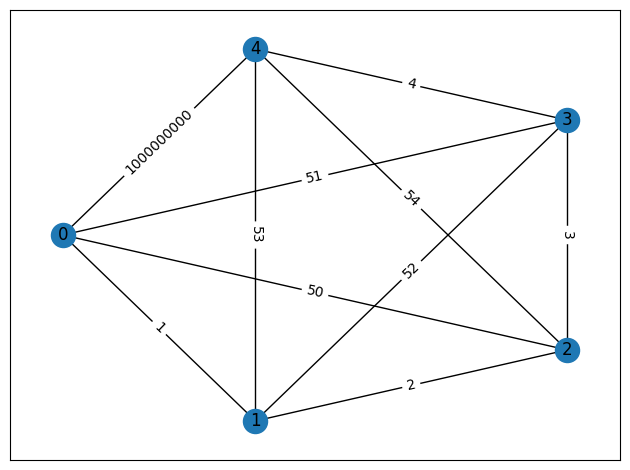

In [14]:
_, ax = plt.subplots(layout="tight")
pos = nx.shell_layout(G)
nx.draw_networkx(G, pos, ax=ax)
edge_labels = {(u, v): G.edges[u, v]["weight"] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
plt.show()

In [15]:
T = nx.minimum_spanning_tree(G)

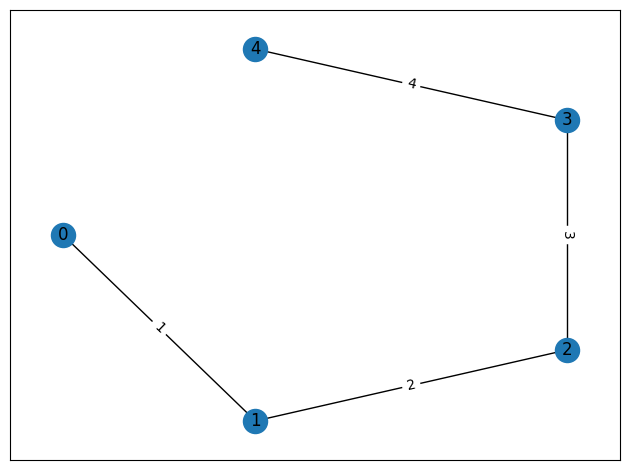

In [16]:
_, ax = plt.subplots(layout="tight")
pos = nx.shell_layout(T)
nx.draw_networkx(T, pos, ax=ax)
edge_labels = {(u, v): T.edges[u, v]["weight"] for u, v in T.edges()}
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels, ax=ax)
plt.show()

Back to the assignment code:

In [17]:
# Check that the cost matrix is symmetric
assert len(cost_matrix) == 5, f"Cost matrix must have 5 rows. Yours has {len(cost_matrix)} rows."
assert all(len(row) == 5 for row in cost_matrix), f"Each row of the cost matrix must have 5 entries."
for i in range(5):
    for j in range(i):
        assert (
            cost_matrix[i][j] == cost_matrix[j][i]
        ), f"Cost matrix fails to be symmetric at entries {(i, j)} and {(j, i)}"
print("Structure of your cost matrix looks OK (3 points).")

Structure of your cost matrix looks OK (3 points).


In [18]:
# MST based TSP approximation
# This code implements the simple MST based shortcutting approach that would
# yield factor of 2 approximation for metric TSPs
def minimum_spanning_tree_tsp(n, cost_matrix):
    G = nx.Graph()
    for i in range(n):
        for j in range(i):
            G.add_edge(i, j, weight=cost_matrix[i][j])
    T = nx.minimum_spanning_tree(G)
    print(f"MST for your graph has the edges {T.edges}")
    mst_cost = 0
    mst_dict = {}  # Store MST as a dictionary
    for i, j in T.edges:
        mst_cost += cost_matrix[i][j]
        if i in mst_dict:
            mst_dict[i].append(j)
        else:
            mst_dict[i] = [j]
        if j in mst_dict:
            mst_dict[j].append(i)
        else:
            mst_dict[j] = [i]
    print(f"MST cost: {mst_cost}")
    print(mst_dict)

    # Form a tour with shortcutting
    def traverse_mst(tour_so_far, cur_node):
        assert cur_node in mst_dict
        next_nodes = mst_dict[cur_node]
        for j in next_nodes:
            if j in tour_so_far:
                continue
            tour_so_far.append(j)
            traverse_mst(tour_so_far, j)

    tour = [0]
    traverse_mst(tour, 0)
    i = 0
    tour_cost = 0
    for j in tour[1:]:
        tour_cost += cost_matrix[i][j]
        i = j
    tour_cost += cost_matrix[i][0]

    return tour, tour_cost

In [19]:
# Optimal TSP tour using MTZ encoding
def mtz_encoding_tsp(n, cost_matrix):
    assert len(cost_matrix) == n, f"Cost matrix is not {n}x{n}"
    assert all(len(row) == n for row in cost_matrix), f"Cost matrix is not {n}x{n}"
    # Create encoding variables
    binary_vars = [
        [LpVariable(f"x_{i}_{j}", cat="Binary") if i != j else None for j in range(n)] for i in range(n)
    ]
    # Add time stamps
    time_stamps = [LpVariable(f"t_{i}", lowBound=0, upBound=n) for i in range(1, n)]
    # Create the problem
    prob = LpProblem("TSP-MTZ", LpMinimize)
    # Add the objective function
    prob += lpSum(
        lpSum(xij * cj if xij is not None else 0 for xij, cj in zip(brow, crow))
        for brow, crow in zip(binary_vars, cost_matrix)
    )
    # Add the degree constraints
    for i in range(n):
        prob += lpSum(xj for xj in binary_vars[i] if xj is not None) == 1
        prob += lpSum(binary_vars[j][i] for j in range(n) if j != i) == 1
    # Add time stamp constraints
    for i in range(1, n):
        for j in range(1, n):
            if i == j:
                continue
            xij = binary_vars[i][j]
            ti = time_stamps[i - 1]
            tj = time_stamps[j - 1]
            prob += tj >= ti + xij - (1 - xij) * (n + 1)  # pyright: ignore
    # Solve the problem
    status = prob.solve(PULP_CBC_CMD(msg=False))
    assert status == constants.LpStatusOptimal, f"Unexpected non-optimal status {status}"
    # Extract the tour
    tour = [0]
    tour_cost = 0
    while len(tour) < n:
        i = tour[-1]
        sols = [j for j, xij in enumerate(binary_vars[i]) if xij is not None and xij.varValue >= 0.999]  # pyright: ignore
        assert len(sols) == 1
        j = sols[0]
        tour_cost += cost_matrix[i][j]
        tour.append(j)
        assert j != 0
    i = tour[-1]
    tour_cost += cost_matrix[i][0]
    return tour, tour_cost

In [20]:
# Test that exact answer is 10^6 times smaller than approximate answer
# Compute MST based approximation
tour, tour_cost = minimum_spanning_tree_tsp(5, cost_matrix)
print(f"MST approximation yields tour {tour} with cost {tour_cost}")

# Compute exact answer
opt_tour, opt_tour_cost = mtz_encoding_tsp(5, cost_matrix)
print(f"Optimal tour is {opt_tour} with cost {opt_tour_cost}")

# Check that the fraction is 1 million times apart
assert (
    tour_cost / opt_tour_cost >= 1e06
), f"The TSP + shortcutting tour must be at least 10^6 times costlier than optimum. In your case, the ratio is {tour_cost / opt_tour_cost}"

print("Test passed: 7 points")

MST for your graph has the edges [(1, 0), (1, 2), (2, 3), (3, 4)]
MST cost: 10
{1: [0, 2], 0: [1], 2: [1, 3], 3: [2, 4], 4: [3]}
MST approximation yields tour [0, 1, 2, 3, 4] with cost 1000000010
Optimal tour is [0, 2, 3, 4, 1] with cost 111
Test passed: 7 points


## Problem 3

In [21]:
def tsp_with_extra_constraints(n, cost_matrix, constraints):
    assert len(cost_matrix) == n, f"Cost matrix is not {n}x{n}"
    assert all(len(row) == n for row in cost_matrix), f"Cost matrix is not {n}x{n}"
    assert all(1 <= i < n and 1 <= j < n and i != j for i, j in constraints)

    # Create decision variables
    binary_vars = [
        [LpVariable(f"x_{{{i},{j}}}", cat=LpBinary) if i != j else None for j in range(n)] for i in range(n)
    ]
    time_stamps = [LpVariable(f"t_{i}", lowBound=0, upBound=n) for i in range(1, n)]

    # Create the problem
    prob = LpProblem("TSP-MTZ-Extra-Constraints", LpMinimize)

    # Add the objective function
    prob += lpSum(
        lpSum(cost_matrix[i][j] * binary_vars[i][j] for j in filter(lambda x: x != i, range(n)))
        for i in range(n)
    )

    # Add the degree constraints
    for i in range(n):
        prob += lpSum(filter(lambda x: x is not None, binary_vars[i])) == 1
        prob += lpSum(binary_vars[j][i] for j in filter(lambda x: x != i, range(n))) == 1

    # Add time stamp constraints
    for i in range(1, n):
        for j in filter(lambda x: x != i, range(1, n)):
            x = binary_vars[i][j]
            prob += time_stamps[j - 1] >= time_stamps[i - 1] + x - (1 - x) * (n + 1)  # pyright: ignore

    # Add extra constraints
    for i, j in constraints:
        prob += time_stamps[j - 1] >= time_stamps[i - 1] + 1

    # Solve the problem
    prob.solve(PULP_CBC_CMD(msg=False))
    status = LpStatus[prob.status]
    assert status == "Optimal", f"Unexpected non-optimal status: {status}"

    # Extract the tour
    tour = [0]

    while len(tour) < n:
        nxt = [j for j, x in enumerate(binary_vars[tour[-1]]) if x is not None and x.varValue > 0]  # pyright: ignore
        assert len(nxt) == 1
        j = nxt[0]
        assert j != 0
        tour.append(j)

    return tour

In [22]:
n = 5
cost_matrix = [
    [None, 3, 4, 3, 5],
    [1, None, 2, 4, 1],
    [2, 1, None, 5, 4],
    [1, 1, 5, None, 4],
    [2, 1, 3, 5, None],
]
constraints = [(3, 4), (1, 2)]
tour = tsp_with_extra_constraints(n, cost_matrix, constraints)
print(f"Tour: {tour}")

tour_cost = 0
i = 0
for j in tour[1:]:
    tour_cost += cost_matrix[i][j]
    i = j
tour_cost += cost_matrix[i][0]
print(f"Cost of your tour: {tour_cost}")
assert abs(tour_cost - 10) <= 0.001, "Expected cost was 10"

for i in range(n):
    num = sum(j == i for j in tour)
    assert num == 1, f"Vertex {i} repeats {num} times in tour"

for i, j in constraints:
    assert tour.index(i) < tour.index(j), f"Tour does not respect constraint {(i, j)}"

print("Test Passed (3 points)")

Tour: [0, 3, 1, 4, 2]
Cost of your tour: 10
Test Passed (3 points)


In [23]:
n = 5
cost_matrix = [
    [None, 3, 4, 3, 5],
    [1, None, 2, 4, 1],
    [2, 1, None, 5, 4],
    [1, 1, 5, None, 4],
    [2, 1, 3, 5, None],
]
constraints = [(4, 3), (1, 2)]
tour = tsp_with_extra_constraints(n, cost_matrix, constraints)
print(f"Tour: {tour}")

tour_cost = 0
i = 0
for j in tour[1:]:
    tour_cost += cost_matrix[i][j]
    i = j
tour_cost += cost_matrix[i][0]
print(f"Cost of your tour: {tour_cost}")
assert abs(tour_cost - 13) <= 0.001, "Expected cost was 13"

for i in range(n):
    num = sum(j == i for j in tour)
    assert num == 1, f"Vertex {i} repeats {num} times in tour"

for i, j in constraints:
    assert tour.index(i) < tour.index(j), f"Tour does not respect constraint {(i, j)}"

print("Test Passed (3 points)")

Tour: [0, 1, 4, 2, 3]
Cost of your tour: 13
Test Passed (3 points)


In [24]:
for trial in range(20):
    print(f"Trial #{trial}")

    n = randint(6, 11)
    cost_matrix = create_cost(n)
    constraints = [(1, 3), (4, 2), (n - 1, 1), (n - 2, 2)]

    tour = tsp_with_extra_constraints(n, cost_matrix, constraints)
    print(f"Tour: {tour}")

    tour_cost = 0
    i = 0
    for j in tour[1:]:
        tour_cost += cost_matrix[i][j]  # pyright: ignore
        i = j
    tour_cost += cost_matrix[i][0]  # pyright: ignore
    print(f"Cost of your tour: {tour_cost}")

    for i in range(n):
        num = sum(j == i for j in tour)
        assert num == 1, f"Vertex {i} repeats {num} times in tour"

    for i, j in constraints:
        assert tour.index(i) < tour.index(j), f"Tour does not respect constraint {(i, j)}"

print("Test Passed (10 points)")

Trial #0
Tour: [0, 7, 10, 8, 1, 5, 3, 9, 6, 4, 2]
Cost of your tour: 10.837000143871597
Trial #1
Tour: [0, 5, 8, 10, 1, 3, 4, 9, 7, 6, 2]
Cost of your tour: 6.265959721163793
Trial #2
Tour: [0, 6, 1, 3, 5, 4, 2]
Cost of your tour: 11.35967238051494
Trial #3
Tour: [0, 4, 7, 6, 1, 5, 3, 2]
Cost of your tour: 11.108627077734383
Trial #4
Tour: [0, 7, 1, 4, 5, 3, 6, 2]
Cost of your tour: 14.466002592266014
Trial #5
Tour: [0, 4, 6, 5, 2, 1, 3]
Cost of your tour: 11.506084007264938
Trial #6
Tour: [0, 8, 9, 10, 4, 2, 1, 7, 6, 5, 3]
Cost of your tour: 8.610333227655596
Trial #7
Tour: [0, 4, 6, 7, 9, 1, 5, 3, 8, 2]
Cost of your tour: 11.590876819355381
Trial #8
Tour: [0, 9, 5, 4, 7, 10, 8, 1, 6, 3, 2]
Cost of your tour: 10.220562304726696
Trial #9
Tour: [0, 6, 7, 4, 1, 2, 5, 3]
Cost of your tour: 11.689797678912537
Trial #10
Tour: [0, 4, 5, 1, 2, 3]
Cost of your tour: 12.33586426071968
Trial #11
Tour: [0, 5, 8, 4, 9, 6, 7, 1, 3, 2]
Cost of your tour: 9.004308097911034
Trial #12
Tour: [0, 9, 8, 1